# Model Evaluation

#### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn as nn
import torch.optim as optim
from torchmetrics.regression import MeanAbsolutePercentageError, MeanAbsoluteError
from tqdm import tqdm
import optuna

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/home/jovyan/environments/smda-project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


### Model Setup

In [2]:
# multimodal model
def get_mlp_layers(input_dim, output_dim, size='medium', for_submodel=True):

    dropout_sub = 0.3
    dropout_fc = 0.2
    dropout = dropout_sub if for_submodel else dropout_fc

    if size == 'small':
        layers = [
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, output_dim)
        ]
    elif size == 'medium':
        layers = [
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, output_dim)
        ]
    elif size == 'large':
        layers = [
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, output_dim)
        ]
    else:
        raise ValueError("size must be 'small', 'medium', or 'large'")
    return nn.Sequential(*layers)

class SubModel(nn.Module):
    def __init__(self, input_dim, output_dim, size='large'):
        super(SubModel, self).__init__()
        self.fc = get_mlp_layers(input_dim, output_dim, size=size, for_submodel=True)

    def forward(self, x):
        return self.fc(x)

class MultimodalModel(nn.Module):
    def __init__(
        self,
        image_input_dim,
        text_input_dim,
        output_dim,
        submodel_size='medium',
        fc_size='medium'      
    ):
        super(MultimodalModel, self).__init__()
        self.image_model = SubModel(image_input_dim, 256, size=submodel_size)
        self.text_model = SubModel(text_input_dim, 256, size=submodel_size)
        self.fc = get_mlp_layers(512, output_dim, size=fc_size, for_submodel=False)

    def forward(self, image_x, text_x):
        image_out = self.image_model(image_x)
        text_out = self.text_model(text_x)
        combined = torch.cat((image_out, text_out), dim=1)
        return self.fc(combined)

### Evaluation Setup

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError
from sklearn.utils import shuffle

def evaluate_model(model, data_loader, device, n_permutations=1000, verbose=True):
    model.eval()
    mae_metric = MeanAbsoluteError().to(device)
    mape_metric = MeanAbsolutePercentageError().to(device)
    all_targets = []
    all_preds = []
    all_video_ids = []

    with torch.no_grad():
        for image_embedding, title_embedding, target, video_id in data_loader:
            image_embedding = image_embedding.to(device)
            title_embedding = title_embedding.to(device)
            target = target.to(device)
            output = model(image_embedding, title_embedding).view(-1)
            all_targets.append(target.cpu().numpy())
            all_preds.append(output.cpu().numpy())
            mae_metric.update(output, target)
            mape_metric.update(output, target)
            all_video_ids.append(video_id)

    # compute all metrics
    mae = mae_metric.compute().item()
    mape = mape_metric.compute().item()
    all_targets = np.concatenate(all_targets)
    all_preds = np.concatenate(all_preds)
    all_video_ids = np.concatenate(all_video_ids)

    # Calculate R-squared
    ss_res = np.sum((all_targets - all_preds) ** 2)
    ss_tot = np.sum((all_targets - np.mean(all_targets)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
    print(f"R-squared: {r_squared:.4f}")

    # Permutation Test
    permuted_maes = []
    for _ in range(n_permutations):
        perm_targets = shuffle(all_targets, random_state=None)
        perm_mae = np.mean(np.abs(all_preds - perm_targets))
        permuted_maes.append(perm_mae)

    permuted_maes = np.array(permuted_maes)
    p_value = np.mean(permuted_maes <= mae)  # lower MAE is better

    print(f"Permutation test p-value (MAE): {p_value:.4f}")
    
    # Bootstrapping    
    def bootstrap_mean_baseline(all_targets, model_mae, model_r2, n_bootstrap=1000, random_state=None):
        rng = np.random.default_rng(random_state)
        mae_scores = []
        r2_scores = []
        n = len(all_targets)

        for _ in range(n_bootstrap):
            sample_idx = rng.integers(0, n, size=n)
            sample_targets = all_targets[sample_idx]
            mean_pred = np.mean(sample_targets)
            mae = np.mean(np.abs(sample_targets - mean_pred))
            
            # calculate R-squared for mean predictor
            ss_res = np.sum((sample_targets - mean_pred) ** 2)
            ss_tot = np.sum((sample_targets - np.mean(sample_targets)) ** 2)
            r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
            
            mae_scores.append(mae)
            r2_scores.append(r2)

        mae_scores = np.array(mae_scores)
        r2_scores = np.array(r2_scores)
        avg_mae = mae_scores.mean()
        avg_r2 = r2_scores.mean()
        mae_ci_lower = np.percentile(mae_scores, 2.5)
        mae_ci_upper = np.percentile(mae_scores, 97.5)
        r2_ci_lower = np.percentile(r2_scores, 2.5)
        r2_ci_upper = np.percentile(r2_scores, 97.5)

        return avg_mae, mae_ci_lower, mae_ci_upper, avg_r2, r2_ci_lower, r2_ci_upper, mae_scores

    avg_mae_baseline, mae_ci_low, mae_ci_high, avg_r2_baseline, r2_ci_low, r2_ci_high, bootstrap_mae_scores = bootstrap_mean_baseline(
        all_targets, model_mae=mae, model_r2=r_squared, n_bootstrap=1000
    )
    if verbose:
        print(f"Bootstrap mean-predictor baseline MAE: {avg_mae_baseline:.4f} "
            f"(95% CI: {mae_ci_low:.4f} – {mae_ci_high:.4f})")
        print(f"Bootstrap mean-predictor baseline R²: {avg_r2_baseline:.4f} "
            f"(95% CI: {r2_ci_low:.4f} – {r2_ci_high:.4f})")
        
        fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

        # 1. Bootstraped distribution of mean prediction
        axes[0].hist(bootstrap_mae_scores, bins=30, alpha=0.7, color='skyblue', density=True)
        axes[0].axvline(mae, color='red', linestyle='--', linewidth=2, label=f"Model MAE ({mae:.4f})")
        axes[0].axvline(avg_mae_baseline, color='black', linestyle='-', linewidth=2, label=f"Baseline mean ({avg_mae_baseline:.4f})")
        axes[0].set_xlabel("MAE of Mean Predictor (Bootstrap Samples)")
        axes[0].set_ylabel("Density")
        axes[0].set_title("Bootstrap Distribution of Mean Predictor MAE")
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # 2. Distribution of true vs predicted
        axes[1].hist(all_targets, bins=30, alpha=0.7, color='blue', label='True', density=True)
        axes[1].hist(all_preds, bins=30, alpha=0.7, color='red', label='Predicted', density=True)
        axes[1].set_xlabel("Score")
        axes[1].set_ylabel("Density")
        axes[1].set_title('Distribution of True vs Predicted Scores')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        # 3. True vs predicted scatte plot
        axes[2].scatter(all_targets, all_preds, alpha=0.5, s=20)
        min_val = min(all_targets.min(), all_preds.min())
        max_val = max(all_targets.max(), all_preds.max())
        axes[2].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect prediction')
        axes[2].set_xlabel('True Score')
        axes[2].set_ylabel('Predicted Score')
        axes[2].set_title(f'True vs Predicted Scatter Plot (R² = {r_squared:.4f})')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return mae, mape, r_squared, p_value, all_targets, all_preds, all_video_ids

## Performance

### Load Data

In [62]:
df_performance = pd.read_parquet("smda/project/data/random_50000_scores_performance.parquet")

image_embedding_file = np.load("smda/project/data/image_embeddings.npz", allow_pickle=True)
image_embeddings = {k: image_embedding_file[k] for k in image_embedding_file.files}
title_embeddings = np.load("smda/project/data/title_embeddings.npz", allow_pickle=True)['arr_0'].item()

In [63]:
class VideoDataset(Dataset):
    def __init__(self, df, image_embeddings, title_embeddings):
        self.df = df
        self.image_embeddings = image_embeddings
        self.title_embeddings = title_embeddings

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_id = row['display_id']
        
        image_embedding = torch.tensor(self.image_embeddings[video_id], dtype=torch.float32)
        title_embedding = torch.tensor(self.title_embeddings[video_id], dtype=torch.float32)
        
        score = torch.tensor(row['performance_score'], dtype=torch.float32)
        
        return image_embedding, title_embedding, score, video_id

In [64]:
# create data split in train, validation and test set and create dataloader
def create_dataloaders(df, image_embeddings, title_embeddings, batch_size=32):
    dataset = VideoDataset(df, image_embeddings, title_embeddings)
    
    train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)
    
    train_dataset = VideoDataset(train_df, image_embeddings, title_embeddings)
    val_dataset = VideoDataset(val_df, image_embeddings, title_embeddings)
    test_dataset = VideoDataset(test_df, image_embeddings, title_embeddings)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

### Load Model + Evaluation

In [65]:
model_path = "smda/project/models/multimodal_model_performance.pth"

study_performance = optuna.load_study(
    study_name="Base_from_embeddings",
    storage="sqlite:///smda/project/optuna_study_optimized_performance.db"
)

best_params_performance = study_performance.best_trial.params

model_path = "smda/project/models/multimodal_model_performance.pth"

submodel_size = best_params_performance["submodel_size"]
fc_size = best_params_performance["fc_size"]
batch_size = best_params_performance["batch_size"]

title_dims = len(next(iter(title_embeddings.values())))
image_dims = len(next(iter(image_embeddings.values())))

model_performance = MultimodalModel(
    image_input_dim=image_dims,
    text_input_dim=title_dims,
    output_dim=1,
    submodel_size=submodel_size,
    fc_size=fc_size
).to(device)


train_loader, val_loader, test_loader = create_dataloaders(df_performance, image_embeddings, title_embeddings, batch_size=batch_size)

# load best model
model_performance.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

Mean Absolute Error (MAE): 1.2983
Mean Absolute Percentage Error (MAPE): 4.8454
R-squared: 0.0878
Permutation test p-value (MAE): 0.0000
Bootstrap mean-predictor baseline MAE: 1.3792 (95% CI: 1.3486 – 1.4096)
Bootstrap mean-predictor baseline R²: 0.0000 (95% CI: 0.0000 – 0.0000)
Permutation test p-value (MAE): 0.0000
Bootstrap mean-predictor baseline MAE: 1.3792 (95% CI: 1.3486 – 1.4096)
Bootstrap mean-predictor baseline R²: 0.0000 (95% CI: 0.0000 – 0.0000)


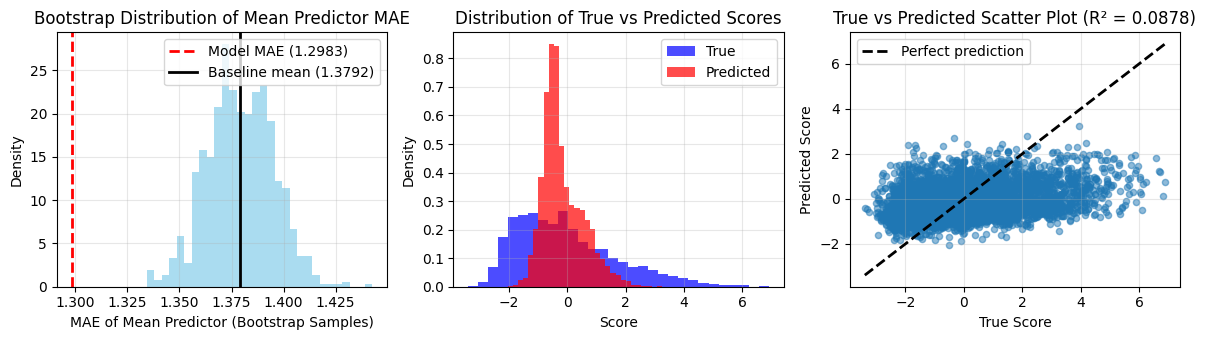

In [66]:
mae, mape, r_squared, p_value, targets, preds, video_ids = evaluate_model(model_performance, test_loader, device, n_permutations=10000)

In [67]:
df_performance_predictions = pd.DataFrame({
    "video_id": video_ids,
    "true_performance_score": targets,
    "predicted_performance_score": preds
})

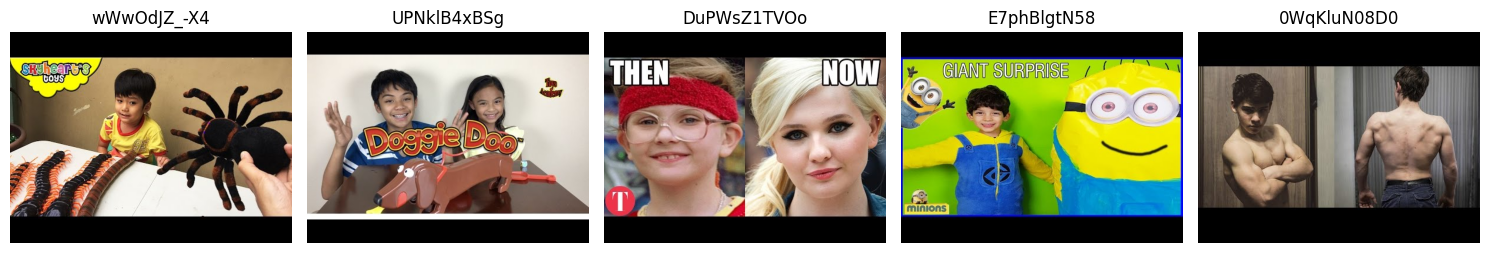

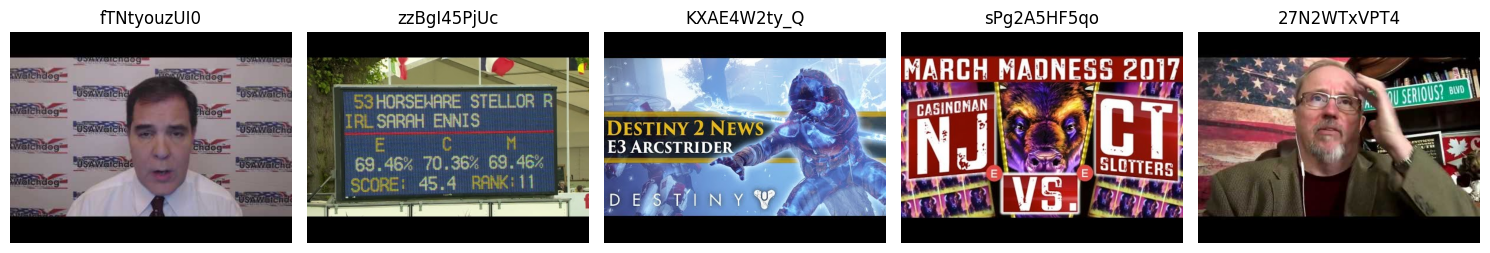

In [68]:
thumbnails_path = "smda/project/data/thumbnails/"

def get_video_data(video_ids):
    import os
    from PIL import Image
    import matplotlib.pyplot as plt

    video_data = {}
    images = []
    ids = []
    titles = []
    
    for vid in video_ids:
        thumbnail_file = os.path.join(thumbnails_path, f"{vid}.jpg")
        title = df_performance.loc[df_performance['display_id'] == vid, 'title'].values[0]
        titles.append(title)
        if os.path.exists(thumbnail_file):
            image = Image.open(thumbnail_file).convert("RGB")
            images.append(image)
            ids.append(vid)
            
            video_data[vid] = {
                "thumbnail": image,
                "title": title
            }
            
        else:
            video_data[vid] = {}

    # Plot images with video IDs as titles
    n = len(images)
    images_per_row = 5
    n_rows = (n + images_per_row - 1) // images_per_row 
    plt.figure(figsize=(3 * images_per_row, 3 * n_rows))
    for i, (vid, img) in enumerate(zip(ids, images)):
        row = i // images_per_row
        col = i % images_per_row
        plt.subplot(n_rows, images_per_row, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(vid)
    plt.tight_layout()
    plt.show()

    return video_data

top_pred = df_performance_predictions.sort_values(by="predicted_performance_score", ascending=False).head(5)
bottom_pred = df_performance_predictions.sort_values(by="predicted_performance_score", ascending=True).head(5)

top_videos = get_video_data(top_pred['video_id'].tolist())
bottom_videos = get_video_data(bottom_pred['video_id'].tolist())
    

In [69]:
top_videos

{'wWwOdJZ_-X4': {'thumbnail': <PIL.Image.Image image mode=RGB size=480x360>,
  'title': 'CREEPY SPIDER and Crawling Insect Kids Toys - Giant Scolopendra, Centipede, Snake, spider toys'},
 'UPNklB4xBSg': {'thumbnail': <PIL.Image.Image image mode=RGB size=480x360>,
  'title': 'Doggie  Doo Family Fun Game Unboxing | Toys Academy'},
 'DuPWsZ1TVOo': {'thumbnail': <PIL.Image.Image image mode=RGB size=480x360>,
  'title': '10 Famous Child Stars Who Became INCREDIBLE Actors'},
 'E7phBlgtN58': {'thumbnail': <PIL.Image.Image image mode=RGB size=480x360>,
  'title': 'GIANT EGG SURPRISE MINION Toys from Despicable Me Fun Kids Video'},
 '0WqKluN08D0': {'thumbnail': <PIL.Image.Image image mode=RGB size=480x360>,
  'title': '14 Years Strongest Kid In The World  Training Hard and Flexing Big in the Gym'}}

In [70]:
bottom_videos

{'fTNtyouzUI0': {'thumbnail': <PIL.Image.Image image mode=RGB size=480x360>,
  'title': 'Greg Hunter-Weekly News Wrap-Up 1.27.17'},
 'zzBgI45PjUc': {'thumbnail': <PIL.Image.Image image mode=RGB size=480x360>,
  'title': 'Thursday #MMBHT Dressage Nos 31 - 53'},
 'KXAE4W2ty_Q': {'thumbnail': <PIL.Image.Image image mode=RGB size=480x360>,
  'title': 'Destiny 2 News - E3 Updates! Arcstrider at E3! Destiny balance updates? GuardianCon!'},
 'sPg2A5HF5qo': {'thumbnail': <PIL.Image.Image image mode=RGB size=480x360>,
  'title': 'March Madness 2017 - (EAST Coast Round #1) - Slot Machine Tournament - Slot Machine Bonus'},
 '27N2WTxVPT4': {'thumbnail': <PIL.Image.Image image mode=RGB size=480x360>,
  'title': 'BREAKING: "Hugh Coronal Hole" Opens On the Sun"'}}

## Quality

In [71]:
df_quality = pd.read_parquet("smda/project/data/random_50000_scores_quality.parquet")

image_embedding_file = np.load("smda/project/data/image_embeddings.npz", allow_pickle=True)
image_embeddings = {k: image_embedding_file[k] for k in image_embedding_file.files}
title_embeddings = np.load("smda/project/data/title_embeddings.npz", allow_pickle=True)['arr_0'].item()

In [72]:
class VideoDataset(Dataset):
    def __init__(self, df, image_embeddings, title_embeddings):
        self.df = df
        self.image_embeddings = image_embeddings
        self.title_embeddings = title_embeddings

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_id = row['display_id']
        
        image_embedding = torch.tensor(self.image_embeddings[video_id], dtype=torch.float32)
        title_embedding = torch.tensor(self.title_embeddings[video_id], dtype=torch.float32)
        
        score = torch.tensor(row['quality_score'], dtype=torch.float32)
        
        return image_embedding, title_embedding, score, video_id

In [73]:
# create data split in train, validation and test set and create dataloader
def create_dataloaders(df, image_embeddings, title_embeddings, batch_size=32):
    dataset = VideoDataset(df, image_embeddings, title_embeddings)
    
    train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)
    
    train_dataset = VideoDataset(train_df, image_embeddings, title_embeddings)
    val_dataset = VideoDataset(val_df, image_embeddings, title_embeddings)
    test_dataset = VideoDataset(test_df, image_embeddings, title_embeddings)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

### Load Model + Evaluation

In [74]:
model_path = "smda/project/models/multimodal_model_quality.pth"

study_quality = optuna.load_study(
    study_name="Quality_prediction_optimization",
    storage="sqlite:///smda/project/optuna_study_optimized_quality.db"
)

best_params_quality = study_quality.best_trial.params

submodel_size = best_params_quality["submodel_size"]
fc_size = best_params_quality["fc_size"]
batch_size = best_params_quality["batch_size"]

title_dims = len(next(iter(title_embeddings.values())))
image_dims = len(next(iter(image_embeddings.values())))

model_quality = MultimodalModel(
    image_input_dim=image_dims,
    text_input_dim=title_dims,
    output_dim=1,
    submodel_size=submodel_size,
    fc_size=fc_size
).to(device)


train_loader, val_loader, test_loader = create_dataloaders(df_quality, image_embeddings, title_embeddings, batch_size=batch_size)

# load best model
model_quality.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

Mean Absolute Error (MAE): 0.9890
Mean Absolute Percentage Error (MAPE): 3.0262
R-squared: 0.2434
Permutation test p-value (MAE): 0.0000
Bootstrap mean-predictor baseline MAE: 1.2423 (95% CI: 1.2172 – 1.2661)
Bootstrap mean-predictor baseline R²: 0.0000 (95% CI: 0.0000 – 0.0000)
Permutation test p-value (MAE): 0.0000
Bootstrap mean-predictor baseline MAE: 1.2423 (95% CI: 1.2172 – 1.2661)
Bootstrap mean-predictor baseline R²: 0.0000 (95% CI: 0.0000 – 0.0000)


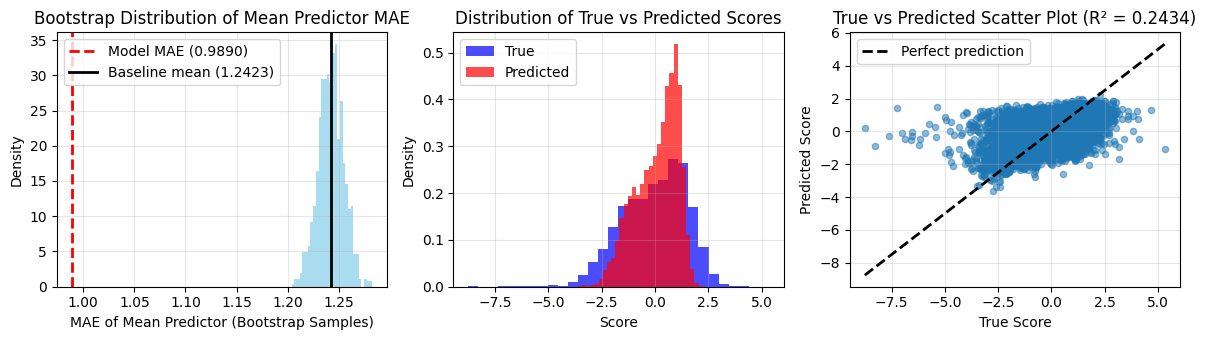

In [75]:
mae, mape, r_squared, p_value, targets, preds, video_ids = evaluate_model(model_quality, test_loader, device, n_permutations=10000)

In [76]:
df_quality_predictions = pd.DataFrame({
    "video_id": video_ids,
    "true_quality_score": targets,
    "predicted_quality_score": preds
})

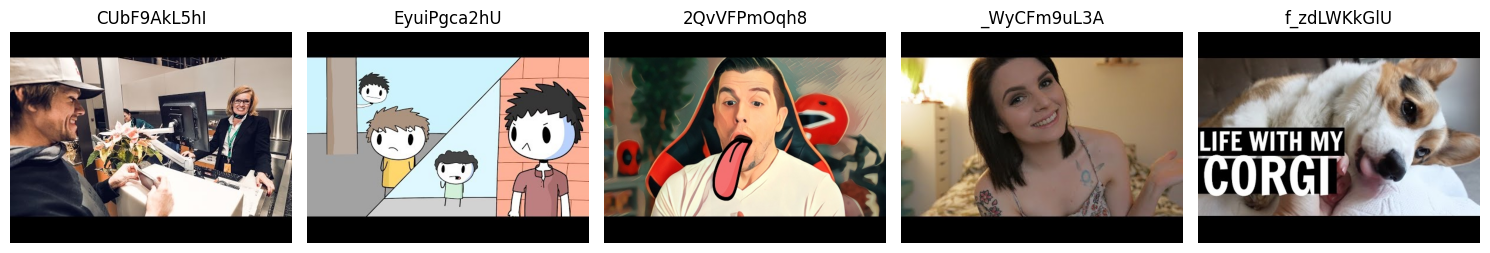

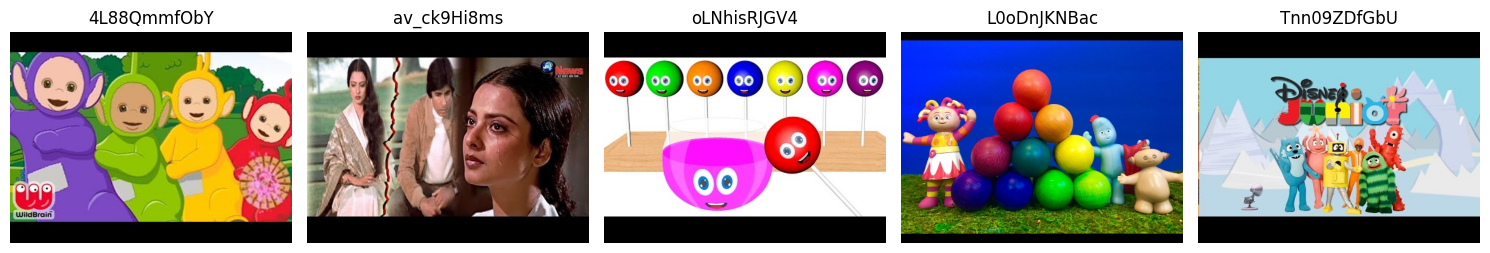

In [77]:
thumbnails_path = "smda/project/data/thumbnails/"

def get_video_data(video_ids):
    import os
    from PIL import Image
    import matplotlib.pyplot as plt

    video_data = {}
    images = []
    ids = []
    titles = []
    
    for vid in video_ids:
        thumbnail_file = os.path.join(thumbnails_path, f"{vid}.jpg")
        title = df_quality.loc[df_quality['display_id'] == vid, 'title'].values[0]
        titles.append(title)
        if os.path.exists(thumbnail_file):
            image = Image.open(thumbnail_file).convert("RGB")
            images.append(image)
            ids.append(vid)
            
            video_data[vid] = {
                "thumbnail": image,
                "title": title
            }
            
        else:
            video_data[vid] = {}

    # Plot images with video IDs as titles
    n = len(images)
    images_per_row = 5
    n_rows = (n + images_per_row - 1) // images_per_row
    plt.figure(figsize=(3 * images_per_row, 3 * n_rows))
    for i, (vid, img) in enumerate(zip(ids, images)):
        row = i // images_per_row
        col = i % images_per_row
        plt.subplot(n_rows, images_per_row, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(vid)
    plt.tight_layout()
    plt.show()

    return video_data

top_pred = df_quality_predictions.sort_values(by="predicted_quality_score", ascending=False).head(5)
bottom_pred = df_quality_predictions.sort_values(by="predicted_quality_score", ascending=True).head(5)

top_videos = get_video_data(top_pred['video_id'].tolist())
bottom_videos = get_video_data(bottom_pred['video_id'].tolist())
    

In [78]:
top_videos

{'CUbF9AkL5hI': {'thumbnail': <PIL.Image.Image image mode=RGB size=480x360>,
  'title': "IT'S BEEN QUITE THE DAY! | VLOG 269"},
 'EyuiPgca2hU': {'thumbnail': <PIL.Image.Image image mode=RGB size=480x360>,
  'title': 'We All Have That ONE Friend'},
 '2QvVFPmOqh8': {'thumbnail': <PIL.Image.Image image mode=RGB size=480x360>,
  'title': "IT'S FINALLY HAPPENING!!! | DISC JAM ON PS4!!"},
 '_WyCFm9uL3A': {'thumbnail': <PIL.Image.Image image mode=RGB size=480x360>,
  'title': 'IM SO SUPER HAPPY RIGHT NOW'},
 'f_zdLWKkGlU': {'thumbnail': <PIL.Image.Image image mode=RGB size=480x360>,
  'title': 'Life With My Corgi'}}

In [79]:
bottom_videos

{'4L88QmmfObY': {'thumbnail': <PIL.Image.Image image mode=RGB size=480x360>,
  'title': 'COMPILATION: Teletubbies Paint Sparkles NEW App Gameplay - Toys Videos 📱 Best Apps for Kids!'},
 'av_ck9Hi8ms': {'thumbnail': <PIL.Image.Image image mode=RGB size=480x360>,
  'title': 'इस वजह से टूटा रेखा-अमिताभ का रिश्ता, ऐसा हुआ था रेखा का हाल | Rekha-Amitabh Breakup'},
 'oLNhisRJGV4': {'thumbnail': <PIL.Image.Image image mode=RGB size=480x360>,
  'title': 'Learn Colors With Lollipop for children Toddlers Kids Videos For Kids'},
 'L0oDnJKNBac': {'thumbnail': <PIL.Image.Image image mode=RGB size=480x360>,
  'title': 'LEARNING Rainbow Colors with In The Night Garden Toys Best Educational Videos for Toddlers!'},
 'Tnn09ZDfGbU': {'thumbnail': <PIL.Image.Image image mode=RGB size=480x360>,
  'title': '639-Disney Junior With Yo Gabba Gabba! Spoof Pixar Lamp Luxo Jr Logo'}}